In [1]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import csv
import images2gif as ig
from scipy.interpolate import interp1d
from scipy.ndimage.interpolation import rotate
import matplotlib.gridspec as gridspec

In [15]:
class OpticalFrames:
    def __init__(self, start, IF):
        self.load_images()
        self.normalise()
        self.start=start
        self.IF=IF
        self.frame_times=np.arange(start, start+12*IF, IF)
    def load_images(self):
        shot=os.path.split(os.getcwd())[-1][0:8] #automatically grab the shot number
        b=[]
        s=[]
        for i in range(1,13):
            if i<10:
                st="0"+str(i)
            else:
                st=str(i) 
            bk_fn=shot+" Background_0"+st+".png"
            bk_im=plt.imread(bk_fn) #read background image
            #bk_im=np.asarray(np.sum(bk_im,2), dtype=float)
            b.append(bk_im)#np.asarray(np.sum(bk_im,2), dtype=float)) #convert to grrayscale
            sh_fn=shot+" Shot_0"+st+".png" 
            sh_im=plt.imread(sh_fn)
            s.append(sh_im)
           
        self.shot=shot
        self.b=b
        self.s=s
    def normalise(self):
        norms=[b_im[100:-100,100:-100].sum() for b_im in self.b]
        n_max=max(norms)
        nn=[n/n_max for n in norms]
        self.s_n=[s_im[100:-100,100:-100]/n for s_im, n in zip(self.s, nn)]
    def logarithm(self, lv_min=-4, lv_max=0.2):
        self.s_l=[np.log(s_im) for s_im in self.s_n]
        self.s_nl=[(np.clip(s_im, a_min=lv_min, a_max=lv_max)-lv_min)/(lv_max-lv_min) for s_im in self.s_l]
    def rotate(self, angle_deg=0):
        self.s_r=[rotate(s_im, angle_deg)for s_im in self.s_nl]
    def crop(self, origin, xcrop=400, ycrop=400):
        x0=origin[1]
        y0=origin[0]
        self.origin=[ycrop,xcrop]
        self.s_c=[s_im[y0-ycrop:y0+ycrop,x0-xcrop:x0+xcrop] for s_im in self.s_r]
    def plot(self, array, frame=1, clim=None, ax=None):
        fin=frame-1
        if ax is None:
            fig, ax=plt.subplots(figsize=(12,8))
        ax.imshow(array[fin], cmap='afmhot', clim=clim)
        ax.axis('off')
        ax.set_title('t='+str(self.frame_times[fin])+' ns', fontsize=22)
    def plot_norm(self, frame=1, clim=None, ax=None):
        self.plot(self.s_n, frame=frame, clim=clim, ax=ax)
    def plot_log(self, frame=1, clim=None, ax=None):
        self.plot(self.s_nl, frame=frame, clim=clim, ax=ax)
    def plot_rot(self, frame=1, clim=None, ax=None):
        self.plot(self.s_r, frame=frame, clim=clim, ax=ax)
    def plot_crop(self, frame=1, clim=None, ax=None):
        self.plot(self.s_c, frame=frame, clim=clim, ax=ax)
    def plot_sequence(self, array=None, frames=list(range(1,13)), clim=None, figsize=None):
        xframes=round(len(frames)/3)
        if array is None:
            array=self.s_c
        if figsize is None:
            figsize=(xframes*4,16)
        fig, ax=plt.subplots(3,xframes, figsize=figsize)
        ax=ax.flatten()
        for fin, f in enumerate(frames):
            fn=f-1 #shift to 0 indexed arrays
            a=ax[fin]
            a.imshow(array[fn], cmap='afmhot', clim=clim)
            a.axis('off')
            a.set_title('t='+str(self.frame_times[fn])+' ns', fontsize=22)
        fig.suptitle("Optical Framing images from "+self.shot, fontsize=32)
        fig.tight_layout(w_pad=0, h_pad=0)
        self.fig=fig
    def save_sequence(self, filename=None):
        if filename is None:
            filename=self.shot+" frame sequence"
        self.fig.savefig(filename+".png")        
    def create_lineout(self, axis=0, frame=1,centre=None,average_over_px=20, mm_range=10, scale=29.1, ax=None):
        px_range=mm_range*scale
        fn=frame-1 #shift to 0 indexed arrays
        if axis is 1:
            d=np.transpose(self.s_c[fn])
            y0=self.origin[1] if centre is None else centre
            x0=self.origin[0]
        if axis is 0:
            d=self.s_c[fn]
            y0=self.origin[0] if centre is None else centre
            x0=self.origin[1]
        section=d[y0-average_over_px:y0+average_over_px, x0-px_range:x0+px_range]
        self.lo=np.mean(section, axis=0)
        self.mm=np.linspace(-px_range, px_range, self.lo.size)/scale
        if ax is None:
            fig, ax=plt.subplots(figsize=(12,8))
        ax.plot(self.mm, self.lo, label='t='+str(self.frame_times[fn])+' ns', lw=4)
    def make_movie(self, clim=[0,1]):
        w=6
        h=w/self.s_c[0].shape[1]*self.s_c[0].shape[0]
        fig, ax=plt.subplots(figsize=(w,h))
        hot_im=[]
        for im in self.s_c:
            ax.imshow(im, cmap='afmhot', clim=clim)
            plt.axis('off')
            fig.tight_layout()
            fig.canvas.draw()
            w,h=fig.canvas.get_width_height()
            buf=np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8)
            buf.shape=(h,w,3)
            hot_im.append(buf)
        shfn=self.shot+" Shot"
        ig.writeGif(shfn+'.gif',hot_im, duration=0.2)
        

In [3]:
cd "C:\Users\jdavies\Google Drive\MAGPIE\data\2015\s1214_15 C Reconnection 12 Frame\s1214_15\s1214_15 shifted

C:\Users\jdavies\Google Drive\MAGPIE\data\2015\s1214_15 C Reconnection 12 Frame\s1214_15\s1214_15 shifted


In [16]:
s=OpticalFrames(168,20)

C:\Users\jdavies\Anaconda3\lib\site-packages\ipykernel\__main__.py:34: RuntimeWarning: divide by zero encountered in log


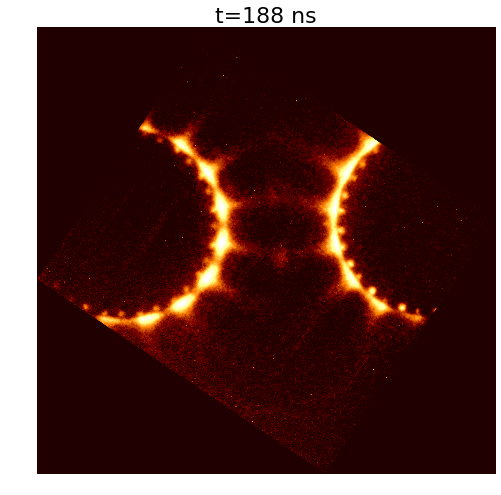

In [17]:
s.logarithm()
s.rotate(-90+56)
s.plot_rot(frame=2)

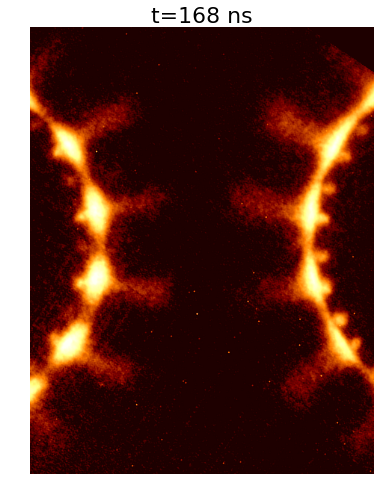

In [18]:
s.crop((512,608), xcrop=230, ycrop=300)
s.plot_crop()

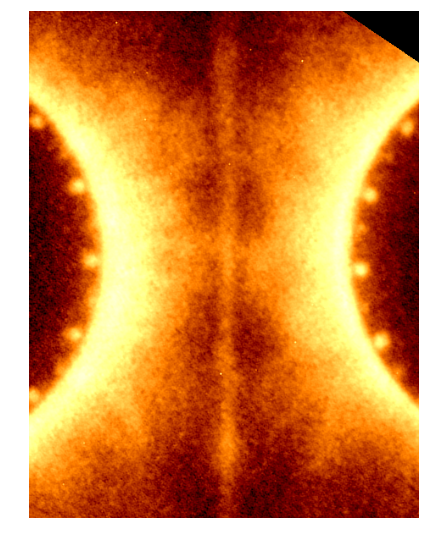

In [66]:
s.make_movie()

<IPython.core.display.Javascript object>


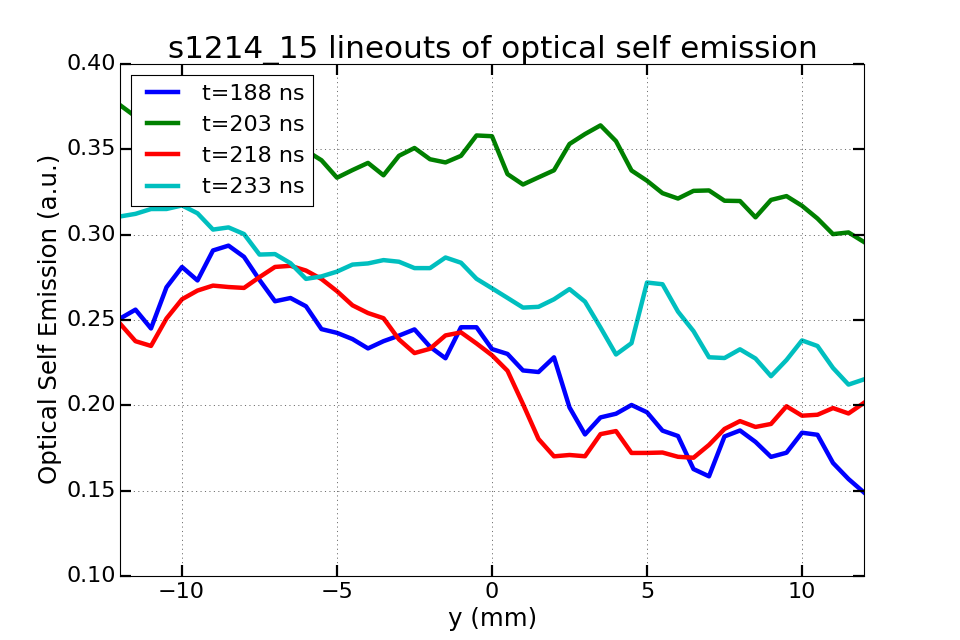

c:\users\jdavies\anaconda3\lib\site-packages\ipykernel\__main__.py:90: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [8]:
fig, ax=plt.subplots(figsize=(12,8))
for i in [1,2,3,4]:
    s.create_lineout(axis=1, frame=i, ax=ax, mm_range=12, average_over_px=10)
ax.legend()

ax.set_xlim([-12,12])#
#ax.set_ylim([0.2, 0.8])

ax.set_xlabel('y (mm)',fontsize=22)
ax.set_ylabel(r'Optical Self Emission (a.u.)',fontsize=22)
ax.set_title(r's1214_15 lineouts of optical self emission', fontsize=28)

ax.tick_params(labelsize=20, pad=5, length=10, width=2)
ax.grid()
ax.legend(fontsize=20, loc=2)

<IPython.core.display.Javascript object>


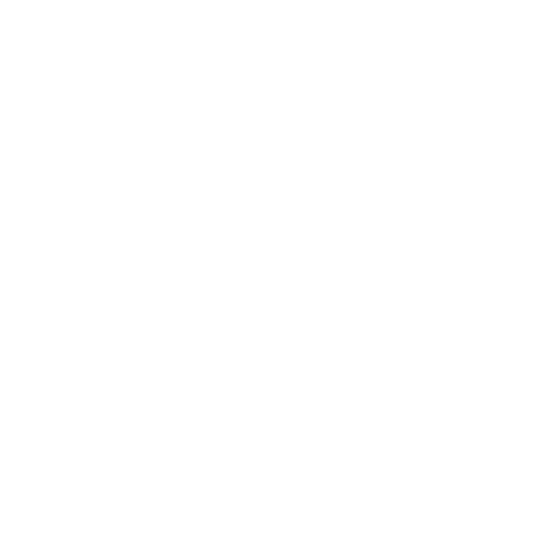

c:\users\jdavies\anaconda3\lib\site-packages\ipykernel\__main__.py:90: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


AttributeError: 'numpy.ndarray' object has no attribute 'axes'

In [10]:
fig, ax=plt.subplots(4, 1, sharex=True,figsize=(7,7))
fig.subplots_adjust(hspace=0, wspace=0)

for f in [1,2,3,4]:
    s.create_lineout(axis=1, frame=f, ax=ax[f-1], mm_range=12, average_over_px=10)
    a.axes.get_yaxis().set_ticks([])
    a.set_xticks(np.arange(-15,16,2.5))
    a.set_ylabel(str(f)+': '+str((f-1)*10+188)+ 'ns', fontsize=16)
    a.grid(True, which='both')
    
ax[0].set_xlim(-12.5,12.5)
ax[2].set_xlabel('y (mm)', fontsize=16)
ax[2].tick_params(labelsize=12)
ax[0].set_title(s.shot+" lineouts through x=0", fontsize=20)
fig.tight_layout()

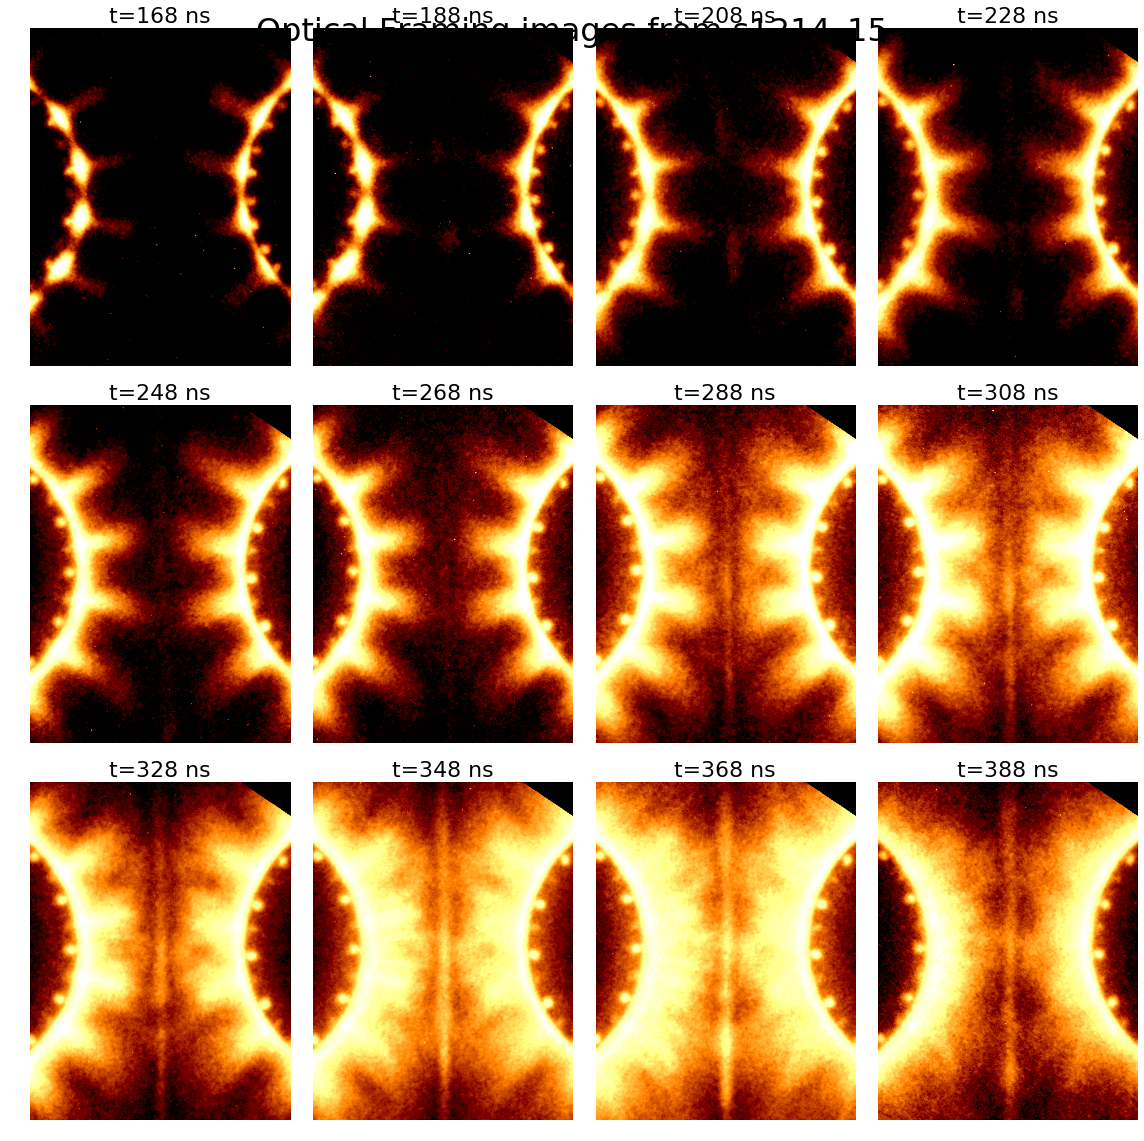

In [19]:
s.plot_sequence(clim=[0.1,0.9], frames=range(1,13))

In [89]:
s.save_sequence()

<IPython.core.display.Javascript object>


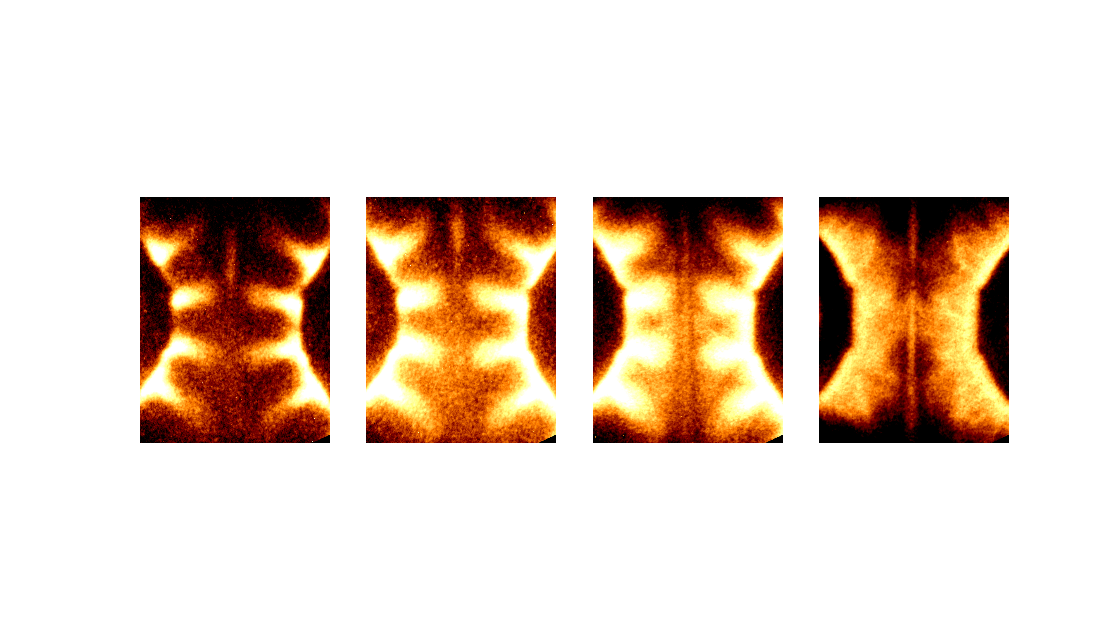

In [12]:
fig, ax=plt.subplots(1,4,figsize=(14,8))
s.plot_crop(frame=1, ax=ax[0], clim=[0.1,0.8])
s.plot_crop(frame=2, ax=ax[1], clim=[0.1,0.8])
s.plot_crop(frame=5, ax=ax[2], clim=[0.2,0.8])
s.plot_crop(frame=11, ax=ax[3], clim=[0.5,1])
for a in ax:
    a.set_title('')

In [ ]:
s.mak

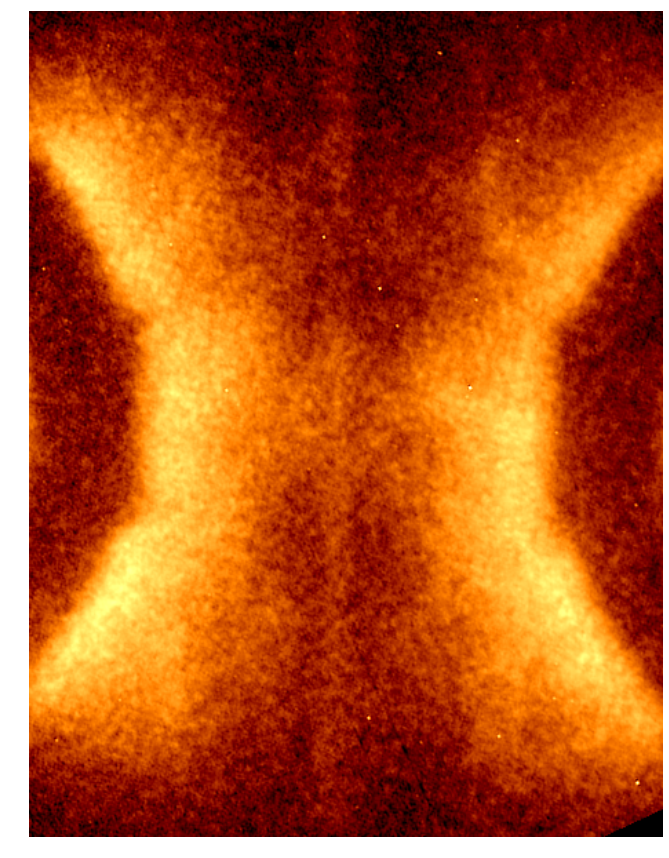

In [22]:
fig, ax=plt.subplots(figsize=(10,12))
hot_im=[]
for im in s.s_c:
    ax.imshow(im, cmap='afmhot', clim=[0,1])
    plt.axis('off')
    fig.tight_layout()
    fig.canvas.draw()
    w,h=fig.canvas.get_width_height()
    buf=np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8)
    buf.shape=(h,w,3)
    hot_im.append(buf)

In [23]:
shfn=" Shot"
ig.writeGif(shfn+'.gif',hot_im, duration=0.2)

In [25]:
s.s_c[0].shape

(600, 460)

In [180]:
fig.savefig('s0120B16 4 out of 12 frames.pdf')

## Old Code

In [3]:
shot=os.path.split(os.getcwd())[-1][0:8] #automatically grab the shot number
b=[]
s=[]
for i in range(1,13):
    if i<10:
        st="0"+str(i)
    else:
        st=str(i) 

    bk_fn=shot+" Background_0"+st+".png"
    bk_im=plt.imread(bk_fn) #read background image
    #bk_im=np.asarray(np.sum(bk_im,2), dtype=float)
    b.append(bk_im)#np.asarray(np.sum(bk_im,2), dtype=float)) #convert to grrayscale
    sh_fn=shot+" Shot_0"+st+".png" 
    sh_im=plt.imread(sh_fn)
    s.append(sh_im)

bb=np.zeros((13, b[0].shape[0], b[0].shape[1])) #create an empty array to store the results
ss=np.zeros((13, s[0].shape[0], s[0].shape[1]))
bb[0]=b[0]
ss[0]=s[0]
shifts=np.zeros((13,2))

In [4]:
#normalise data to intensity of background images
norms=[b_im[100:-100,100:-100].sum() for b_im in b]
n_max=max(norms)
nn=[n/n_max for n in norms]
s_n=[s_im[100:-100,100:-100]/n for s_im, n in zip(s, nn)]

In [5]:
#normalise data to maximum intensity in any one frame?
#s_max=max([s_im.max() for s_im in s_n])
#s_nn=[s_im/s_max for s_im in s_n]

In [5]:
#logarithm of data
s_l=[np.log(s_im) for s_im in s_n]
lv_min=-4
lv_max=0.2
s_nl=[(np.clip(s_im, a_min=lv_min, a_max=lv_max)-lv_min)/(lv_max-lv_min) for s_im in s_l]

C:\Users\jdavies\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: RuntimeWarning: divide by zero encountered in log
  from ipykernel import kernelapp as app


In [6]:
#rotate
#dx=287-572
#dy=115-531
#theta=180/np.pi*np.arctan(dx/dy)
s_r=[rotate(s_im, 24.5)for s_im in s_nl]

In [7]:
x0=550
y0=620
s_c=[s_im[y0-400:y0+400,x0-300:x0+300] for s_im in s_r]

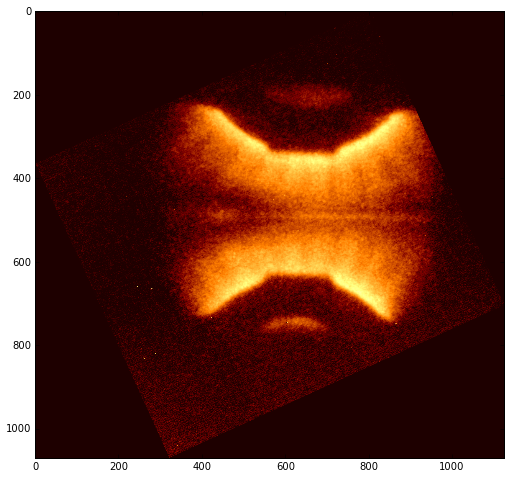

In [10]:
fig, ax=plt.subplots(figsize=(12,8))
ax.imshow(s_r[11], cmap='afmhot', clim=None)

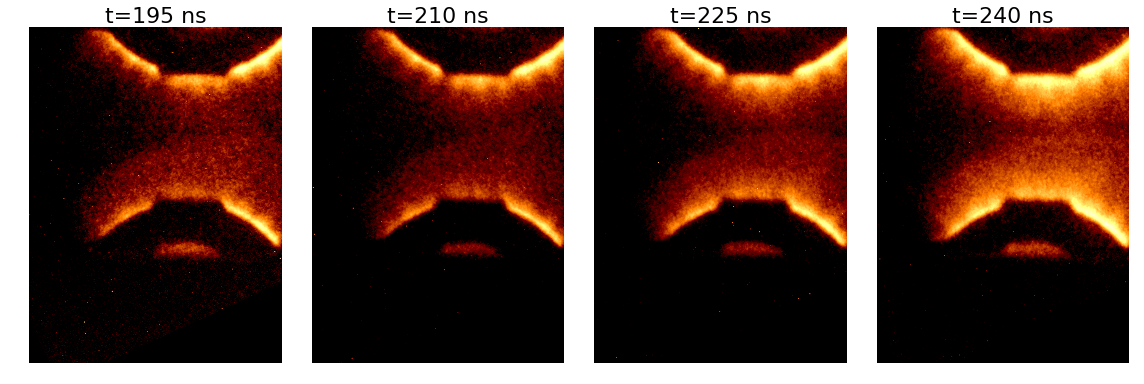

In [9]:
fig, ax=plt.subplots(1,4, figsize=(16,8))
for ain, a in enumerate(ax):
    a.imshow(s_c[ain+1], cmap='afmhot', clim=[0,1])
    a.axis('off')
    a.set_title('t='+str(ain*15+195)+' ns', fontsize=22)
fig.tight_layout(w_pad=0)



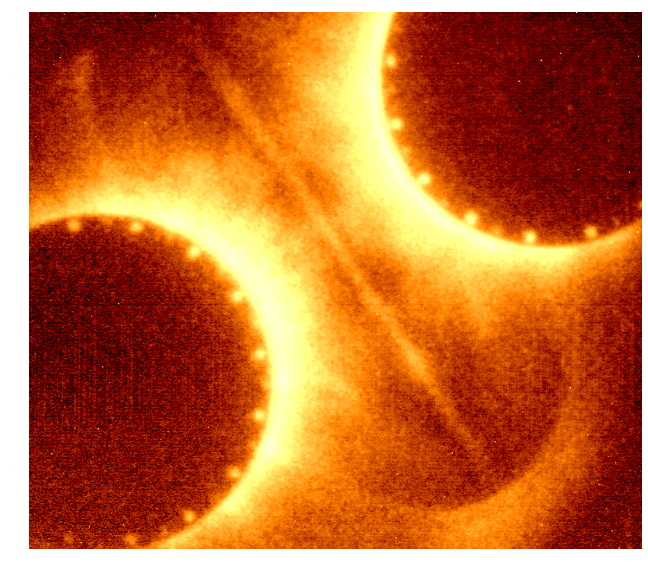

In [65]:
fig, ax=plt.subplots(figsize=(12,8))
hot_im=[]
for im in s_nl:
    ax.imshow(im, cmap='afmhot', clim=[0,1])
    plt.axis('off')
    fig.tight_layout()
    fig.canvas.draw()
    w,h=fig.canvas.get_width_height()
    buf=np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8)
    buf.shape=(h,w,3)
    hot_im.append(buf)

In [66]:
shfn=shot+" Shot"
ig.writeGif(shfn+'.gif',hot_im, duration=0.2)

In [22]:
in_lv=[0, 0.1, 0.5, 1.0]
out_lv=[0, 0.8, 1.0, 1.0]
f=interp1d(in_lv, out_lv, kind='linear')
s_c=[f(s_im) for s_im in s_nn]

In [14]:
shfn=shot+" Shot_c"
ig.writeGif(shfn+'.gif',, duration=0.5)

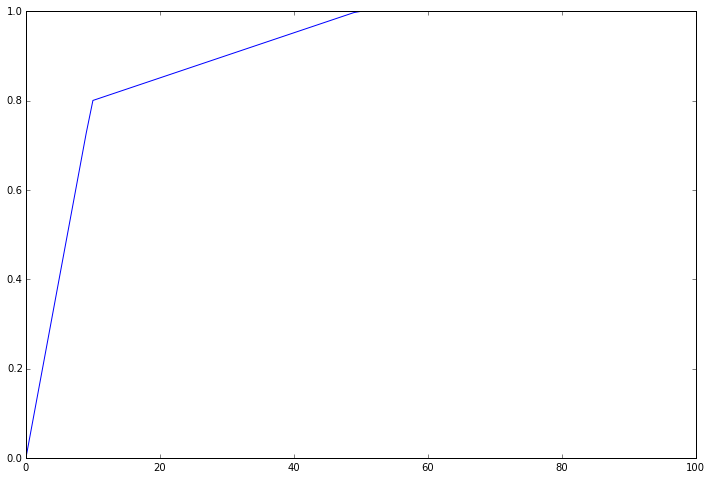

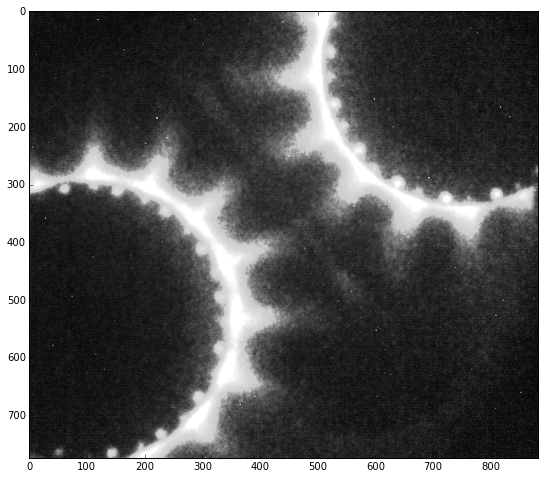

In [23]:
fig, ax=plt.subplots(figsize=(12,8))
ax.plot(f(np.linspace(0,1.0,100)))
fig, ax=plt.subplots(figsize=(12,8))
ax.imshow(f(s_nn[3]), cmap='gray', clim=[0,1])

In [12]:
26/255

0.10196078431372549

# New Code

In [21]:
shot=os.path.split(os.getcwd())[-1][0:8] #automatically grab the shot number
s=[]


for i in range(1,13):
    if i<10:
        st="0"+str(i)
    else:
        st=str(i)
    sh_fn=shot+" Shot_0"+st+".png" 
    sh_im=plt.imread(sh_fn)
    s.append(sh_im)
    

shfn=shot+" Shot"
ig.writeGif(shfn+'.gif',s, duration=0.2)